In [ ]:
import numpy as np
import pandas as pd
import random
import pickle

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import seaborn as sns
import cebra
from cebra import CEBRA

from dataframe.csv_utils import (
    load_data_from_csv,
)
from data_utils import (
    load_data_from_dir,
)
from labels import get_behavioral_labels
from plotting import subplot_confusion_matrix
from constants import SUEJECT_BATCHES, AUDIO_BLOCKS
from features.constants import Feature, MARKER_TO_FEATURE

data_dir = "../CleandDataV2/"
random.seed(33)

## Helper functions

In [ ]:
from features.psd import get_psd_by_channel, get_psd
from biomarkers import EEG_CHANEL_NAMES
from labels import get_raw_labels, get_label_means
from feature_extraction import EEG_BANDS
from resample.resample import (
    get_validation_indexes,
    upsample_by_attention,
    get_resampled_list_index,
    slice_data_by_seconds,
)


def get_psd_by_channel_band(block_data, channel_type: str, srate: int, feature):
    psd_data = []
    num_trials = block_data.shape[0]
    # loop through all trials: time -> frequency
    for t in range(num_trials):
        all_channel_psd = []
        for i, c in enumerate(EEG_CHANEL_NAMES):
            if not c.startswith(channel_type):
                continue

            psd = get_psd(block_data[t, i, :], srate, EEG_BANDS[feature])
            all_channel_psd.append(psd)

        all_channel_psd = np.concatenate(all_channel_psd)
        psd_data.append(all_channel_psd)

    return np.stack(psd_data, axis=0)


def get_features(block_data, marker, channel_type: str, srate: int, feature):
    if marker == "EEG":
        return get_psd_by_channel_band(block_data, channel_type, srate, feature)
    if feature == Feature.ECG_HF or feature == Feature.EGG_FILTERED:
        return block_data[:, 0, :]
    elif feature == Feature.ECG_LF or feature == Feature.EGG_PHASE:
        return block_data[:, 1, :]
    elif feature == Feature.ECG_LFHF or feature == Feature.EGG_AMPLITUDE:
        return block_data[:, 2, :]


def get_block_features(
    blocks, subject_data, marker, channel, feature, with_sliced: bool = False
):
    features = []

    for b in blocks:
        block_data = subject_data[b]
        if with_sliced:
            srate = block_data.get_srate(marker)
            sliced_data = slice_data_by_seconds(
                block_data.get_all_data()[marker], srate, 4
            )
            psd_data = get_features(sliced_data, marker, channel, srate, feature)
        else:
            psd_data = get_psd_by_channel(block_data, marker, channel, feature)

        features = np.vstack((psd_data, features)) if len(features) > 0 else psd_data

    return features


def get_categorical_labels(blocks, subject_data):
    behavioral_labels = []

    for b in blocks:
        block_data = subject_data[b]
        v_label = block_data.get_labels()
        a_label = block_data.get_labels("arousal")

        labels = [
            get_behavioral_labels(v_label[i], a_label[i]) for i in range(len(v_label))
        ]
        behavioral_labels.extend(labels)

    return behavioral_labels


def get_label_category(labels, label_type, v_thred, a_thred):
    threshold = a_thred if label_type == "arousal" else v_thred
    return [0 if p < threshold else 1 for p in labels]


def get_channel_feature_to_data(subject_data, marker: str = "EEG"):
    sliced_channel_feature_to_data = {"A": {}, "B": {}, "C": {}, "D": {}}
    for c in sliced_channel_feature_to_data.keys():
        for f in EEG_BANDS.keys():
            raw_data = get_block_features(
                AUDIO_BLOCKS, subject_data, marker, c, f, True
            )
            sliced_channel_feature_to_data[c][f] = raw_data

    return sliced_channel_feature_to_data


def get_feature_to_data(subject_data, marker: str = "EEG"):
    if marker == "EEG":
        return get_channel_feature_to_data(subject_data, marker)

    sliced_feature_to_data = {marker: {f: {} for f in MARKER_TO_FEATURE[marker]}}
    for f in sliced_feature_to_data[marker].keys():
        raw_data = get_block_features(AUDIO_BLOCKS, subject_data, marker, "", f, True)
        sliced_feature_to_data[marker][f] = raw_data

    return sliced_feature_to_data

## Load data and process features

### Slicing

In [ ]:
import os

marker = "EEG"
num_slice_per_trial = 5

# [2001, 2003, 2017, 2026, 2028, 2033,  2037, 2041]
subject_list = []
#marker_features = []
valence_labels, arousal_labels, attention_labels = [], [], []
label_thresholds = []
for d in os.listdir(data_dir):
    dir_name = data_dir + d
    if not os.path.isdir(dir_name):
        continue

    subject_data = load_data_from_dir(dir_name)
    #features = get_feature_to_data(subject_data, marker)
    vl, arl, atl = get_raw_labels(AUDIO_BLOCKS, subject_data, num_slice_per_trial)

    subject_list.append(d)
    #marker_features.append(features)
    valence_labels.append(vl)
    arousal_labels.append(arl)
    attention_labels.append(atl)
    label_thresholds.append(get_label_means(subject_data))

In [ ]:
# Read dictionary pkl file
with open('./eeg_features2/all_features.pkl', 'rb') as fp:
    marker_features = pickle.load(fp)
    print('Person dictionary')
marker_features.shape

### No slicing

In [ ]:
marker = "EEG"
# [2001, 2003, 2017, 2026, 2028, 2033,  2037, 2041]
subj = 2041
subject_data = subj_to_data[subj]
num_slice_per_trial = 1

channel_feature_to_data = {"A": {}, "B": {}, "C": {}, "D": {}}
for c in ["A", "B", "C", "D"]:
    for f in EEG_BANDS.keys():
        raw_data = get_block_features(AUDIO_BLOCKS, subject_data, marker, c, f)
        channel_feature_to_data[c][f] = raw_data

## Model Training

### Dataset utils

In [5]:
from plotting import plot_roc_curve
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score, accuracy_score
# from importlib import reload
# import features.constants

# reload(features.constants)
from features.constants import Feature

def _train_test_split(data, labels, attention_labels, val_indexes: list = []):
    if len(val_indexes) == 0:
        val_indexes = get_validation_indexes()

    train_indexes = list(set(range(len(labels))) - set(val_indexes))
    # randomly sample without attention weights
    resampled_list = random.choices(
        np.arange(0, len(train_indexes), 1), weights=None, k=len(train_indexes) * 4
    )

    train_labels = np.array(labels)[train_indexes]#[resampled_list]
    train_data = data[train_indexes]#[resampled_list]

    val_data = data[val_indexes]
    val_label = np.array(labels)[val_indexes]
    return train_data, train_labels, val_data, val_label

def get_all_spectral_features(
    feature_to_data: dict, val_indexes, attention_labels, labels
):
    all_spetral_psd = [feature_to_data[f.name] for f in EEG_BANDS.keys()]
    all_spetral_psd = np.hstack(all_spetral_psd)
    return [
        _train_test_split(all_spetral_psd, labels, attention_labels, val_indexes[i])
        for i in range(len(val_indexes))
    ]


def get_all_channel_features(data: dict, val_indexes, attention_labels, labels):
    all_spetral_psd = []
    for _, feature_to_data in data.items():
        spetral_psd = [feature_to_data[f] for f in EEG_BANDS.keys()]
        all_spetral_psd.extend(spetral_psd)

    all_spetral_psd = np.hstack(all_spetral_psd)
    return [
        _train_test_split(all_spetral_psd, labels, attention_labels, val_indexes[i])
        for i in range(len(val_indexes))
    ]


def prepare_dataset(
    data,
    val_indexes,
    attention_labels,
    labels,
    has_all_spectral: bool = False,
    filtered_channel: str = "",
):
    if filtered_channel == "ALL":
        return {
            "ALL": {
                Feature.ALL_SPECTRAL: get_all_channel_features(
                    data, val_indexes, attention_labels, labels
                )
            }
        }

    dataset_dict = {k: {} for k in data.keys()}
    for channel, feature_to_data in data.items():
        if len(feature_to_data) == 0 or (
            channel != filtered_channel and len(filtered_channel) > 0
        ):
            continue

        if has_all_spectral:
            dataset_dict[channel][Feature.ALL_SPECTRAL] = get_all_spectral_features(
                feature_to_data, val_indexes, attention_labels, labels
            )
            continue

        for f, neural_data in feature_to_data.items():
            # Prepare the data
            dataset_dict[channel][f] = [
                _train_test_split(neural_data, labels, attention_labels, val_indexes[i])
                for i in range(len(val_indexes))
            ]
    return dataset_dict

### Training utils

In [43]:
# CEBRA hyper-parameters
OUTPUT_DIM = 8
MAX_HIDDEN_UNITS = 256
from model.embedding import get_embeddings

# output_dim, max_hidden_units only needed for CEBRA
def run_knn_decoder(
    dataset,
    method,
    threshold,
    output_dim,
    max_hidden_units,
):
    y_pred, y_pred_cat, all_embeddings = [], [], []
    for _, (train_data, train_labels, val_data, _) in enumerate(dataset):
        embedding, val_embedding = get_embeddings(
            train_data=train_data,
            val_data=val_data,
            train_labels=train_labels,
            use_pca=(method == "PCA"),
            out_dim= 6 if method == "PCA" else output_dim,
            num_hidden_units=max_hidden_units,
        )
        all_embeddings.append(embedding)
        # 4. Train the decoder on training embedding and labels
        # train_true_cat = get_label_category(train_labels, label_type)
        decoder = cebra.KNNDecoder()
        decoder.fit(embedding, np.array(train_labels))

        # score = decoder.score(val_embedding, np.array(val_labels))
        prediction = decoder.predict(val_embedding)
        y_pred.append(prediction)
        y_pred_cat.append([0 if p < threshold else 1 for p in prediction])

    return y_pred, y_pred_cat, all_embeddings

def _plot_embeddings_breakdown(list_embedding_tuple, method, label_type):
    import plotly.express as px

    for (title, embeddings, embedding_labels) in list_embedding_tuple:
        if 'GAMMA' in title:
            components = embeddings
            color = embedding_labels
            break

    n_components = components.shape[-1]
    labels = {str(i): f"L {i+1}" for i in range(n_components)}
    
    fig = px.scatter_matrix(
        components,
        labels=labels,
        dimensions=range(n_components),
        color=color,
        range_color=[0, 1],
        #size_max=3,
        title=f'{method} embedding - {label_type}',
        height=800, width=800
    )
    
    fig.update_layout({"xaxis"+str(i+1): dict(showticklabels = False) for i in range(n_components)})
    fig.update_layout({"yaxis"+str(i+1): dict(showticklabels = False) for i in range(n_components)})
    fig.update_traces(marker=dict(size=3))
    fig.update_traces(diagonal_visible=False)
    fig.show()

def _plot_umap_embeddings(list_embedding_tuple, method, label_type):
    from umap import UMAP
    for (title, embeddings, embedding_labels) in list_embedding_tuple:
        if 'GAMMA' in title:
            components = embeddings
            color = embedding_labels
            break

    fig, axes = plt.subplots(
        nrows=3,
        sharey=True,
        ncols=2,
        figsize=(2 * 5, 3 * 5),
    )
    a = [0.0001, 0.001, 0.1, 1, 10, 50]
    for idx, ax in enumerate(axes.flat):
        umap2d = UMAP(n_components=2, a=0.0001, b=2)
        proj_2d = umap2d.fit_transform(components)
        y = ax.scatter(
            proj_2d[:, 0],
            proj_2d[:, 1],
            cmap="cool",
            c=color,
            s=5,
            vmin=0,
            vmax=1,
        )
        ax.set_title(title)
        yc = plt.colorbar(y, fraction=0.03, pad=0.05, ticks=np.linspace(0, 1, 9))
        yc.ax.tick_params(labelsize=10)
        yc.ax.set_title("score", fontsize=10)

def _umap_visualization(components):
    from umap import UMAP
    umap2d = UMAP(n_components=2, a=0.0001, b=2)
    return umap2d.fit_transform(components)

def _tsne_visualization(components):
    from sklearn.manifold import TSNE
    tsne2d = TSNE(n_components=2, random_state=0) 
    return tsne2d.fit_transform(components) 

def _plot_embeddings(list_embedding_tuple, method, label_type, visualization_func):
    n_row, n_col = (2, 3) if len(list_embedding_tuple) == 6 else (1, 4)
    fig, axes = plt.subplots(
        nrows=n_row,
        sharey=True,
        ncols=n_col,
        figsize=(n_col * 5, n_row * 5),
    )
    for idx, (title, embeddings, embedding_labels) in enumerate(list_embedding_tuple):
        proj_2d = visualization_func(embeddings)
        y = axes.flat[idx].scatter(
            proj_2d[:, 0],
            proj_2d[:, 1],
            cmap="cool",
            c=embedding_labels,
            s=5,
            vmin=0,
            vmax=1,
        )
        axes.flat[idx].set_title(title)
        yc = plt.colorbar(y, fraction=0.03, pad=0.05, ticks=np.linspace(0, 1, 9))
        yc.ax.tick_params(labelsize=10)
        yc.ax.set_title("score", fontsize=10)    
        
    fig.suptitle(f'{visualization_func.__name__}:{method} embedding - {label_type}')   

def decode_marker_data(
    dataset_dict,
    label_type,
    v_thred,
    a_thred,
    method,
    threshold,
    plot_roc: bool = False,
    plot_embed: bool = False,
):
    f1_score_data = {k: {} for k in dataset_dict.keys()}
    accuracy = {k: {} for k in dataset_dict.keys()}
    list_embedding_tuple = []
    for channel, feature_to_data in dataset_dict.items():
        if len(feature_to_data) == 0:
            continue

        for f, dataset in feature_to_data.items():
            val_true_cat = [
                get_label_category(val_labels, label_type, v_thred, a_thred)
                for _, (_, _, _, val_labels) in enumerate(dataset)
            ]

            y_pred, val_pred_cat, all_embeddings = run_knn_decoder(
                dataset,
                method,
                threshold,
                OUTPUT_DIM,
                MAX_HIDDEN_UNITS,
            )

            if plot_roc:
                plot_roc_curve(y_pred, val_true_cat, method, label_type, channel, f)

            score = [
                f1_score(y_pred=val_pred_cat[i], y_true=val_true_cat[i])
                for i in range(len(val_pred_cat))
            ]
            ac_scores = [
                accuracy_score(y_pred=val_pred_cat[i], y_true=val_true_cat[i])
                for i in range(len(val_pred_cat))
            ]
            if plot_embed:
                max_score_index = np.array(ac_scores).argmax(axis=0)
                mean_acc = round(np.mean(ac_scores),2) #round(ac_scores[max_score_index], 2)
                list_embedding_tuple.append(
                    (
                        f"{channel} {f} CV Mean Acc:{mean_acc}",
                        all_embeddings[max_score_index],
                        dataset[max_score_index][1],
                    )
                )

            f1_score_data[channel][f] = np.mean(score)
            accuracy[channel][f] = np.mean(ac_scores)

    # if len(list_embedding_tuple) > 0:
    #     _plot_embeddings(list_embedding_tuple, method, label_type, _umap_visualization)
    #     _plot_embeddings(list_embedding_tuple, method, label_type, _tsne_visualization)  
       
    return list_embedding_tuple, accuracy

### Cross Validation

In [7]:
from resample.resample import get_consecutive_validation_indexes

n_step_trial = 3
val_indexes = [
    get_consecutive_validation_indexes(
        len(valence_labels[0]), len(AUDIO_BLOCKS), num_slice_per_trial, i, n_step_trial
    )
    for i in range(1, 13, n_step_trial)
]
print(len(val_indexes), val_indexes)

4 [[5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214], [20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229], [35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244], [50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 180, 181, 182, 183, 184, 185, 186, 

### Get subjects summary

In [44]:
def get_feature_names_and_mean_scores(
    dataset_dict, accuracy, marker: str, filtered_channel: str
):
    if marker != "EEG":
        return list(dataset_dict[marker].keys()), [
            accuracy[marker][f] for f in all_feature_name
        ]

    if len(filtered_channel) == 0:
        all_feature_name = list(dataset_dict.keys())
        mean_scores = [accuracy[c][Feature.ALL_SPECTRAL] for c in all_feature_name]
    else:
        all_feature_name = list(accuracy[filtered_channel].keys())
        mean_scores = [accuracy[filtered_channel][f] for f in all_feature_name]

    return all_feature_name, mean_scores


subject_accuracy_summary = {
    "subject": [],
    "channel": [],
    "label_type": [],
    "cv_mean_score": [],
}

###CHANGE ME####
method = 'CEBRA'
filtered_channel = "C"
combined_all_spectral = True
plot_roc = False
plot_embeddings = True
###############

subject_to_embedding = { s: {'valence': [], 'arousal': []} for s in subject_list}
for idx in range(len(subject_list)):
    # if subject_list[idx] != '2041':
    #     continue
    subj = subject_list[idx]
    print('decoding subject...', subj)

    v_thred, a_thred = label_thresholds[idx]
    for lt in ["valence", "arousal"]:
        labels = valence_labels[idx] if lt == "valence" else arousal_labels[idx]
        thred = v_thred if lt == "valence" else a_thred

        dataset_dict = prepare_dataset(
            marker_features[idx],
            val_indexes,
            [],
            labels,
            combined_all_spectral,
            filtered_channel,
        )

        subject_to_embedding[subj][lt], accuracy = decode_marker_data(
            dataset_dict, lt, v_thred, a_thred, method, thred, plot_roc, plot_embeddings
        )

        all_feature_name, mean_scores = get_feature_names_and_mean_scores(
            dataset_dict, accuracy, marker, filtered_channel
        )

        subject_accuracy_summary["subject"].extend(
            [subj] * len(all_feature_name)
        )
        subject_accuracy_summary["channel"].extend(all_feature_name)
        subject_accuracy_summary["cv_mean_score"].extend(mean_scores)
        subject_accuracy_summary["label_type"].extend([lt] * len(all_feature_name))

subject_accuracy_summary = pd.DataFrame(subject_accuracy_summary)
subject_accuracy_summary["subject"] = subject_accuracy_summary["subject"].astype(int)

decoding subject... 2040
decoding subject... 2013
decoding subject... 2022
decoding subject... 2025
decoding subject... 2046
decoding subject... 2041
decoding subject... 2024
decoding subject... 2012
decoding subject... 2037
decoding subject... 2001
decoding subject... 2039
decoding subject... 2006
decoding subject... 2038
decoding subject... 2007
decoding subject... 2000
decoding subject... 2009
decoding subject... 2036
decoding subject... 2031
decoding subject... 2017
decoding subject... 2028
decoding subject... 2010
decoding subject... 2026
decoding subject... 2019
decoding subject... 2021
decoding subject... 2044
decoding subject... 2043
decoding subject... 2020
decoding subject... 2018
decoding subject... 2011
decoding subject... 2016
decoding subject... 2029
decoding subject... 2042
decoding subject... 2045
decoding subject... 2034
decoding subject... 2033
decoding subject... 2005
decoding subject... 2002
decoding subject... 2003
decoding subject... 2004
decoding subject... 2032


In [ ]:
subject_accuracy_summary["channel"] = subject_accuracy_summary["channel"].astype(str)
subject_accuracy_summary.to_csv('CEBRA_wo_resampled_C_spectral.csv')

## Plot CV mean score

In [ ]:
data = subject_accuracy_summary
title = "Without resample - CEBRA:spectral breakdown"  #
g = sns.swarmplot(
    data=data,
    x="label_type",
    y="cv_mean_score",
    hue="channel",
    alpha=0.6,
    dodge=True,
    legend=False,
)
g.set_ylim((0.35, 1))

df_means = (
    data.groupby(["label_type", "channel"])["cv_mean_score"].agg("mean").reset_index()
)
pp = sns.pointplot(
    x="label_type",
    y="cv_mean_score",
    data=df_means,
    hue="channel",
    dodge=0.6,
    linestyles="",
    errorbar=None,
    scale=2.5,
    markers="_",
    hue_order=[
        "DELTA",
        "THETA",
        "ALPHA",
        "BETA1",
        "BETA2",
        "GAMMA",
    ],
    order=["valence", "arousal"],
)

sns.move_legend(pp, "upper right", bbox_to_anchor=(1.2, 1))
g.set_title(title)

In [ ]:
sns.relplot(
    data=subject_accuracy_summary,
    x="ari_scores", y="cv_mean_score", hue="label_type", col="channel",
)

## Plot embeddings

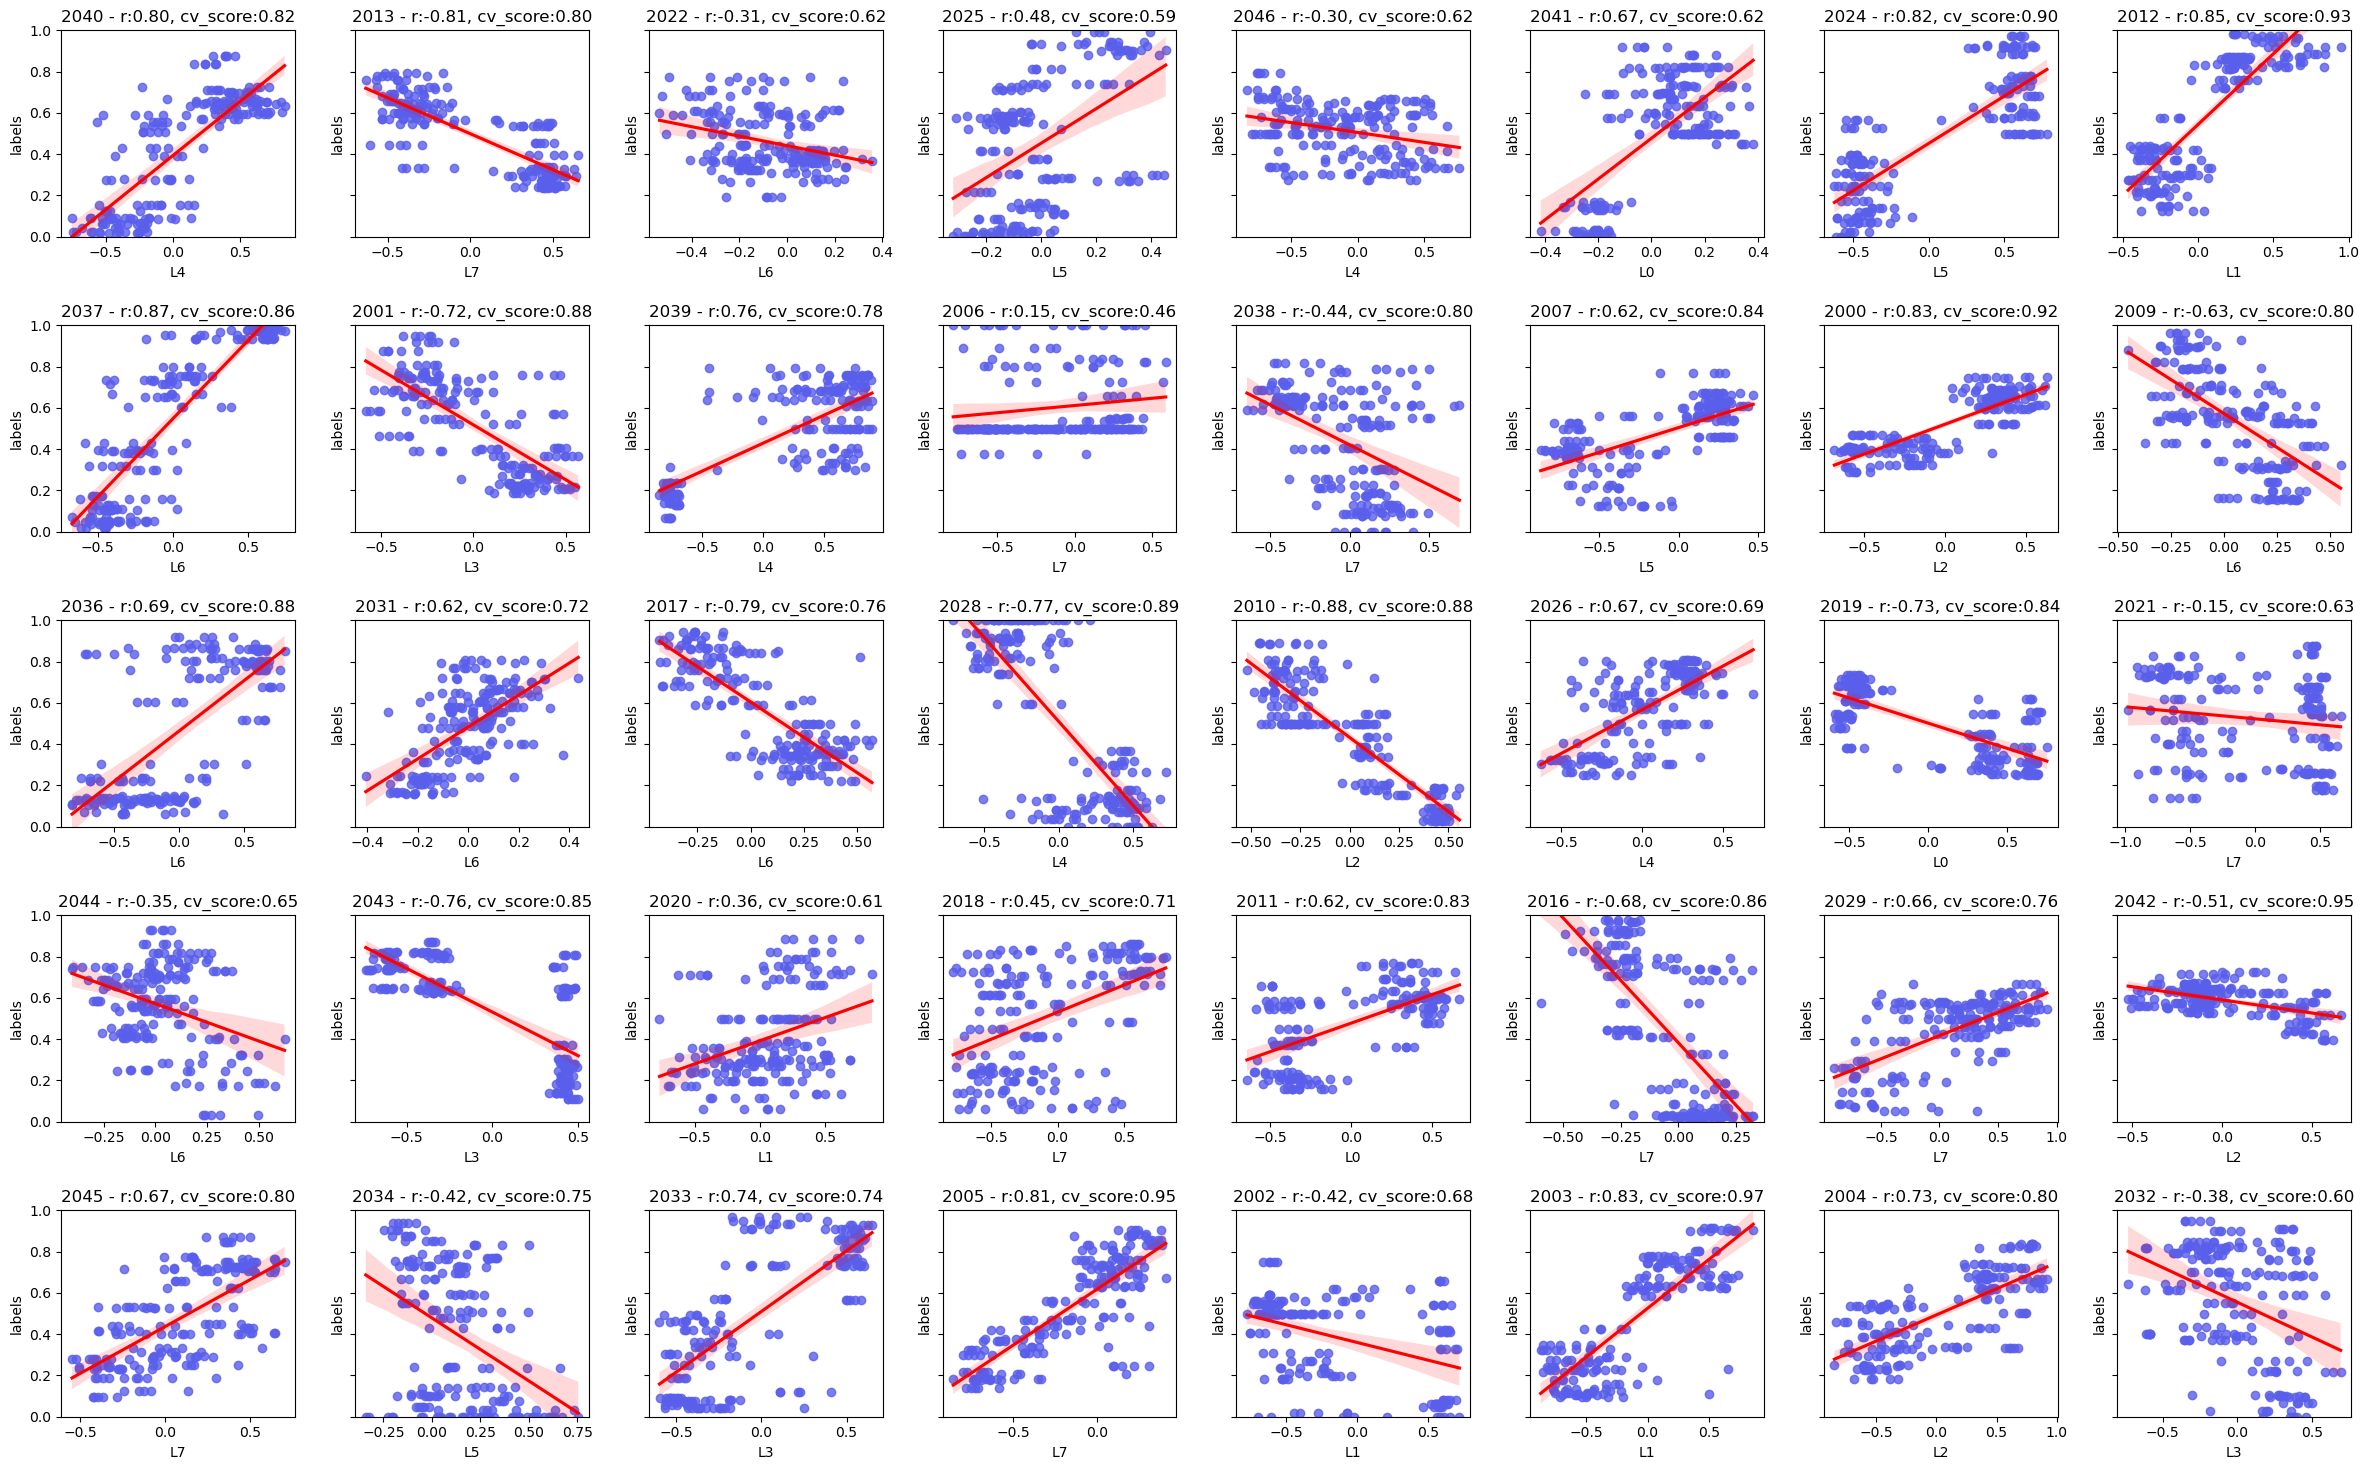

In [88]:
colorMap = {'valence': '#94b325', 'arousal': '#595eeb'}
label_type = 'arousal'
best_embedding_idx = []
acc = subject_accuracy_summary[subject_accuracy_summary['label_type'] == label_type]

for i, s in enumerate(subject_list):
    
    _, embeddings, embedding_labels = subject_to_embedding[s][label_type][0]
    abs_corr = []
    for idx in range(embeddings.shape[-1]):
        corr = np.corrcoef(embeddings[:, idx], embedding_labels)[0, 1]
        abs_corr.append(np.abs(corr))
    
    max_score_index = np.array(abs_corr).argmax(axis=0)
    best_embedding_idx.append(max_score_index)

n_row, n_col = (5, 8)
f, axarr = plt.subplots(n_row, n_col, figsize=(3 * n_col, 3 * n_row), sharey=True)
for idx, ax in enumerate(axarr.flat):
    s = subject_list[idx]
    s_acc = acc[acc['subject'] == int(s)]['cv_mean_score'].values[0]

    l = f'L{best_embedding_idx[idx]}'
    _, embeddings, embedding_labels = subject_to_embedding[s][label_type][0]

    result = pd.DataFrame({l: embeddings[:, best_embedding_idx[idx]], 'labels': embedding_labels})
    sns.regplot(data=result, ci=99, x=l, y='labels', color=colorMap[label_type], line_kws=dict(color="r"), ax=ax)
    corr = np.corrcoef(result[l], embedding_labels)[0, 1]
    ax.set_title(f'{s} - r:{corr:.2f}, cv_score:{s_acc:.2f}')
    ax.set(ylim=(0, 1))
f.tight_layout(pad=1.8)

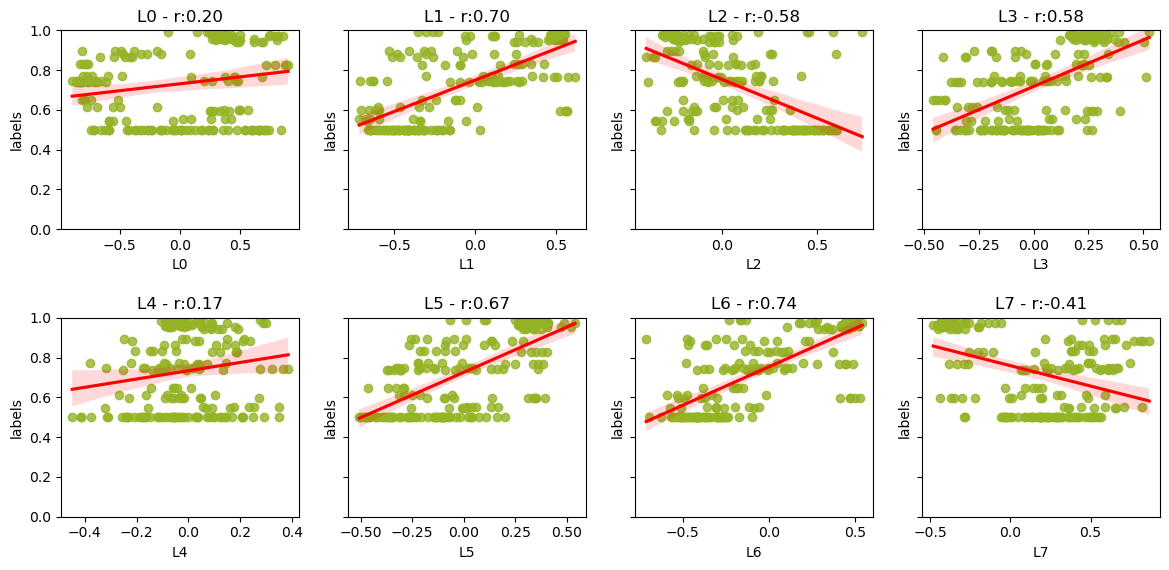

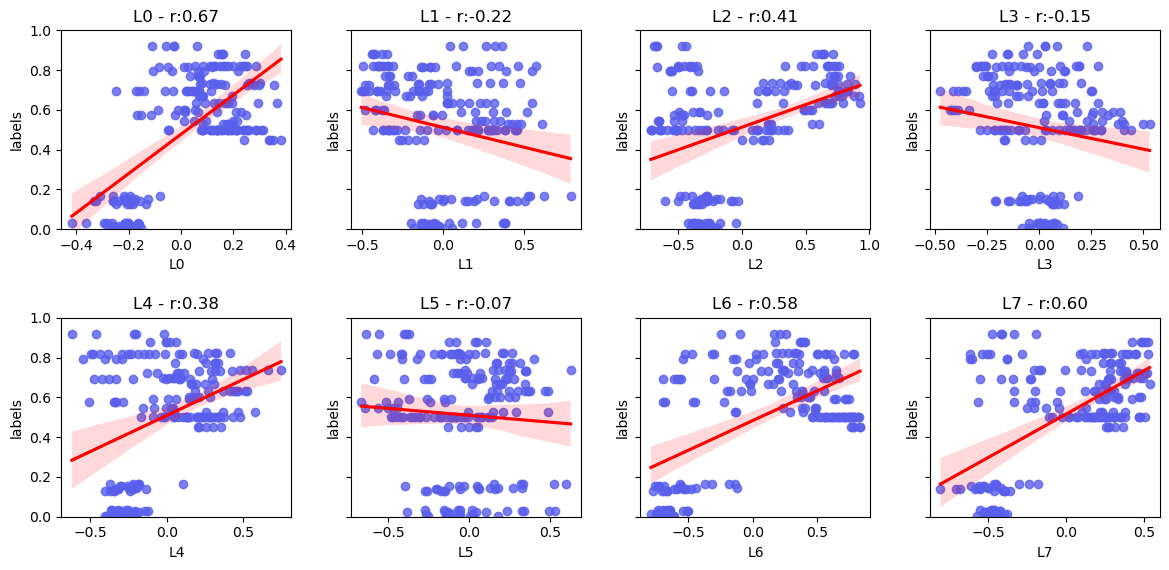

In [90]:
for label_type in ["valence", "arousal"]:
    n_row, n_col = (2, 4)
    f, axarr = plt.subplots(n_row, n_col, figsize=(3 * n_col, 3 * n_row), sharey=True)
    for idx, ax in enumerate(axarr.flat):
        s = '2041'
        l = f'L{idx}'
        _, embeddings, embedding_labels = subject_to_embedding[s][label_type][0]

        result = pd.DataFrame({l: embeddings[:, idx], 'labels': embedding_labels})
        sns.regplot(data=result, ci=99, x=l, y='labels', color=colorMap[label_type], line_kws=dict(color="r"), ax=ax)
        corr = np.corrcoef(result[l], embedding_labels)[0, 1]
        ax.set_title(f'{l} - r:{corr:.2f}')
        ax.set(ylim=(0, 1))
    f.tight_layout(pad=1.8)

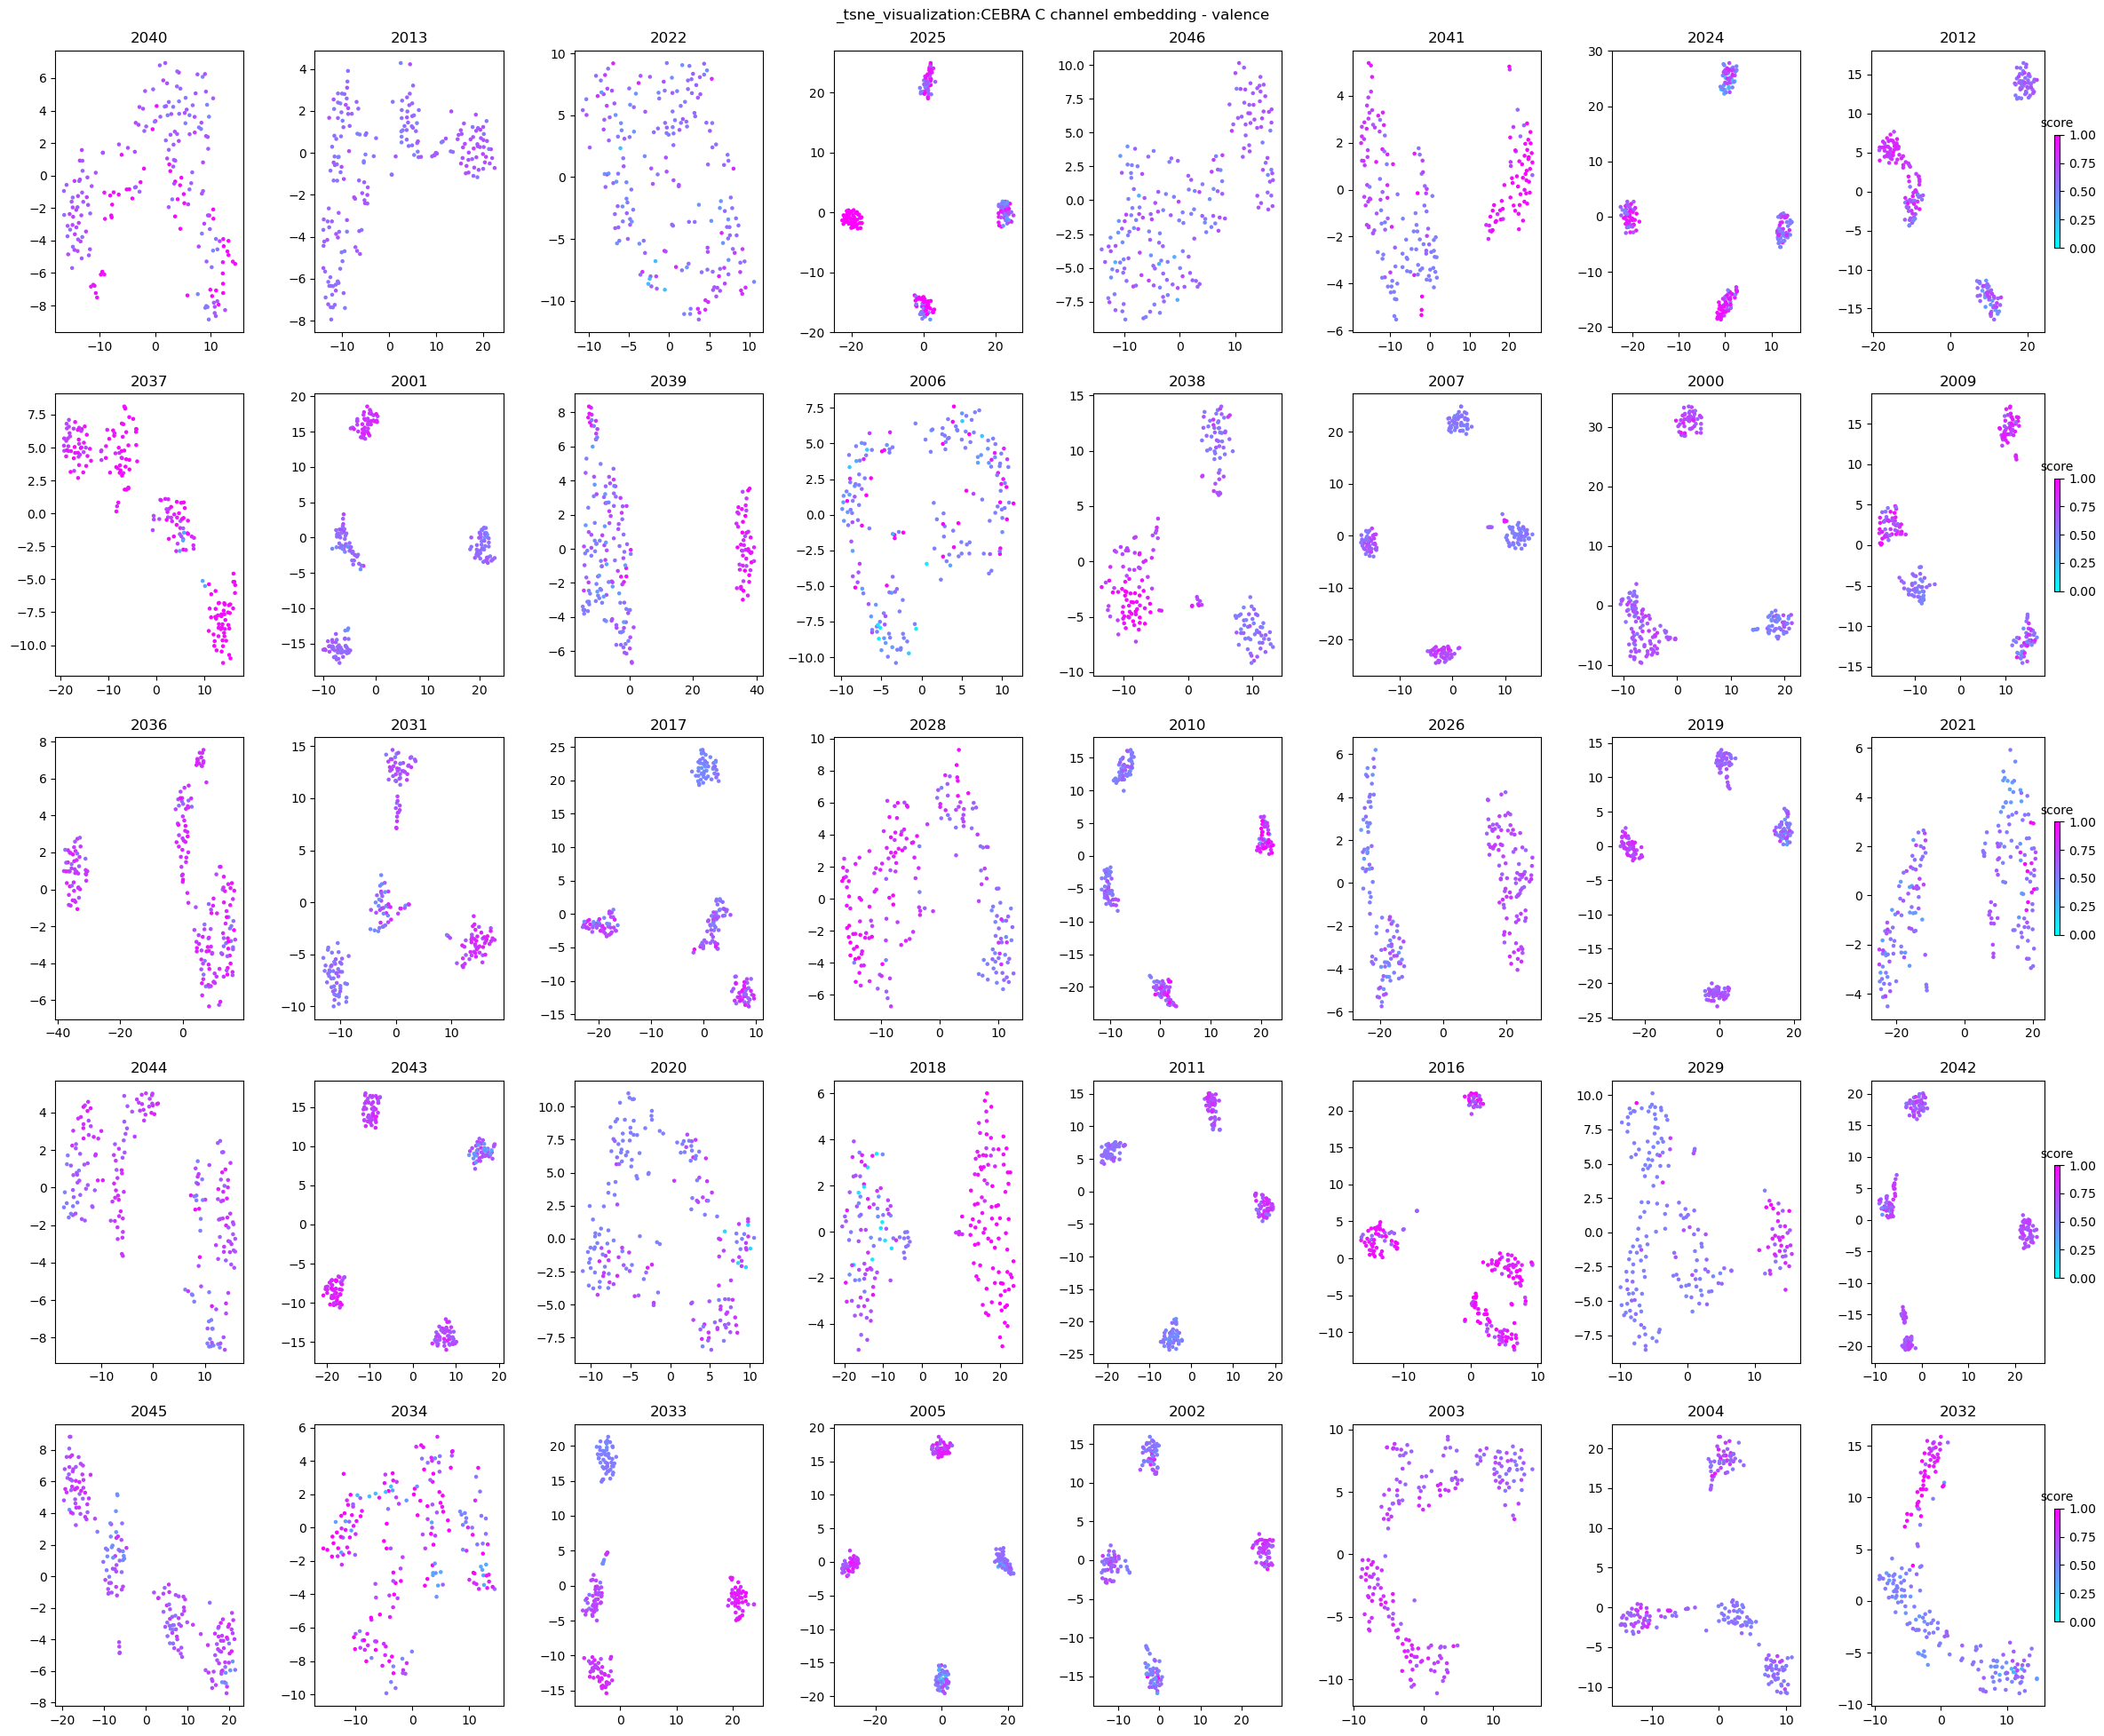

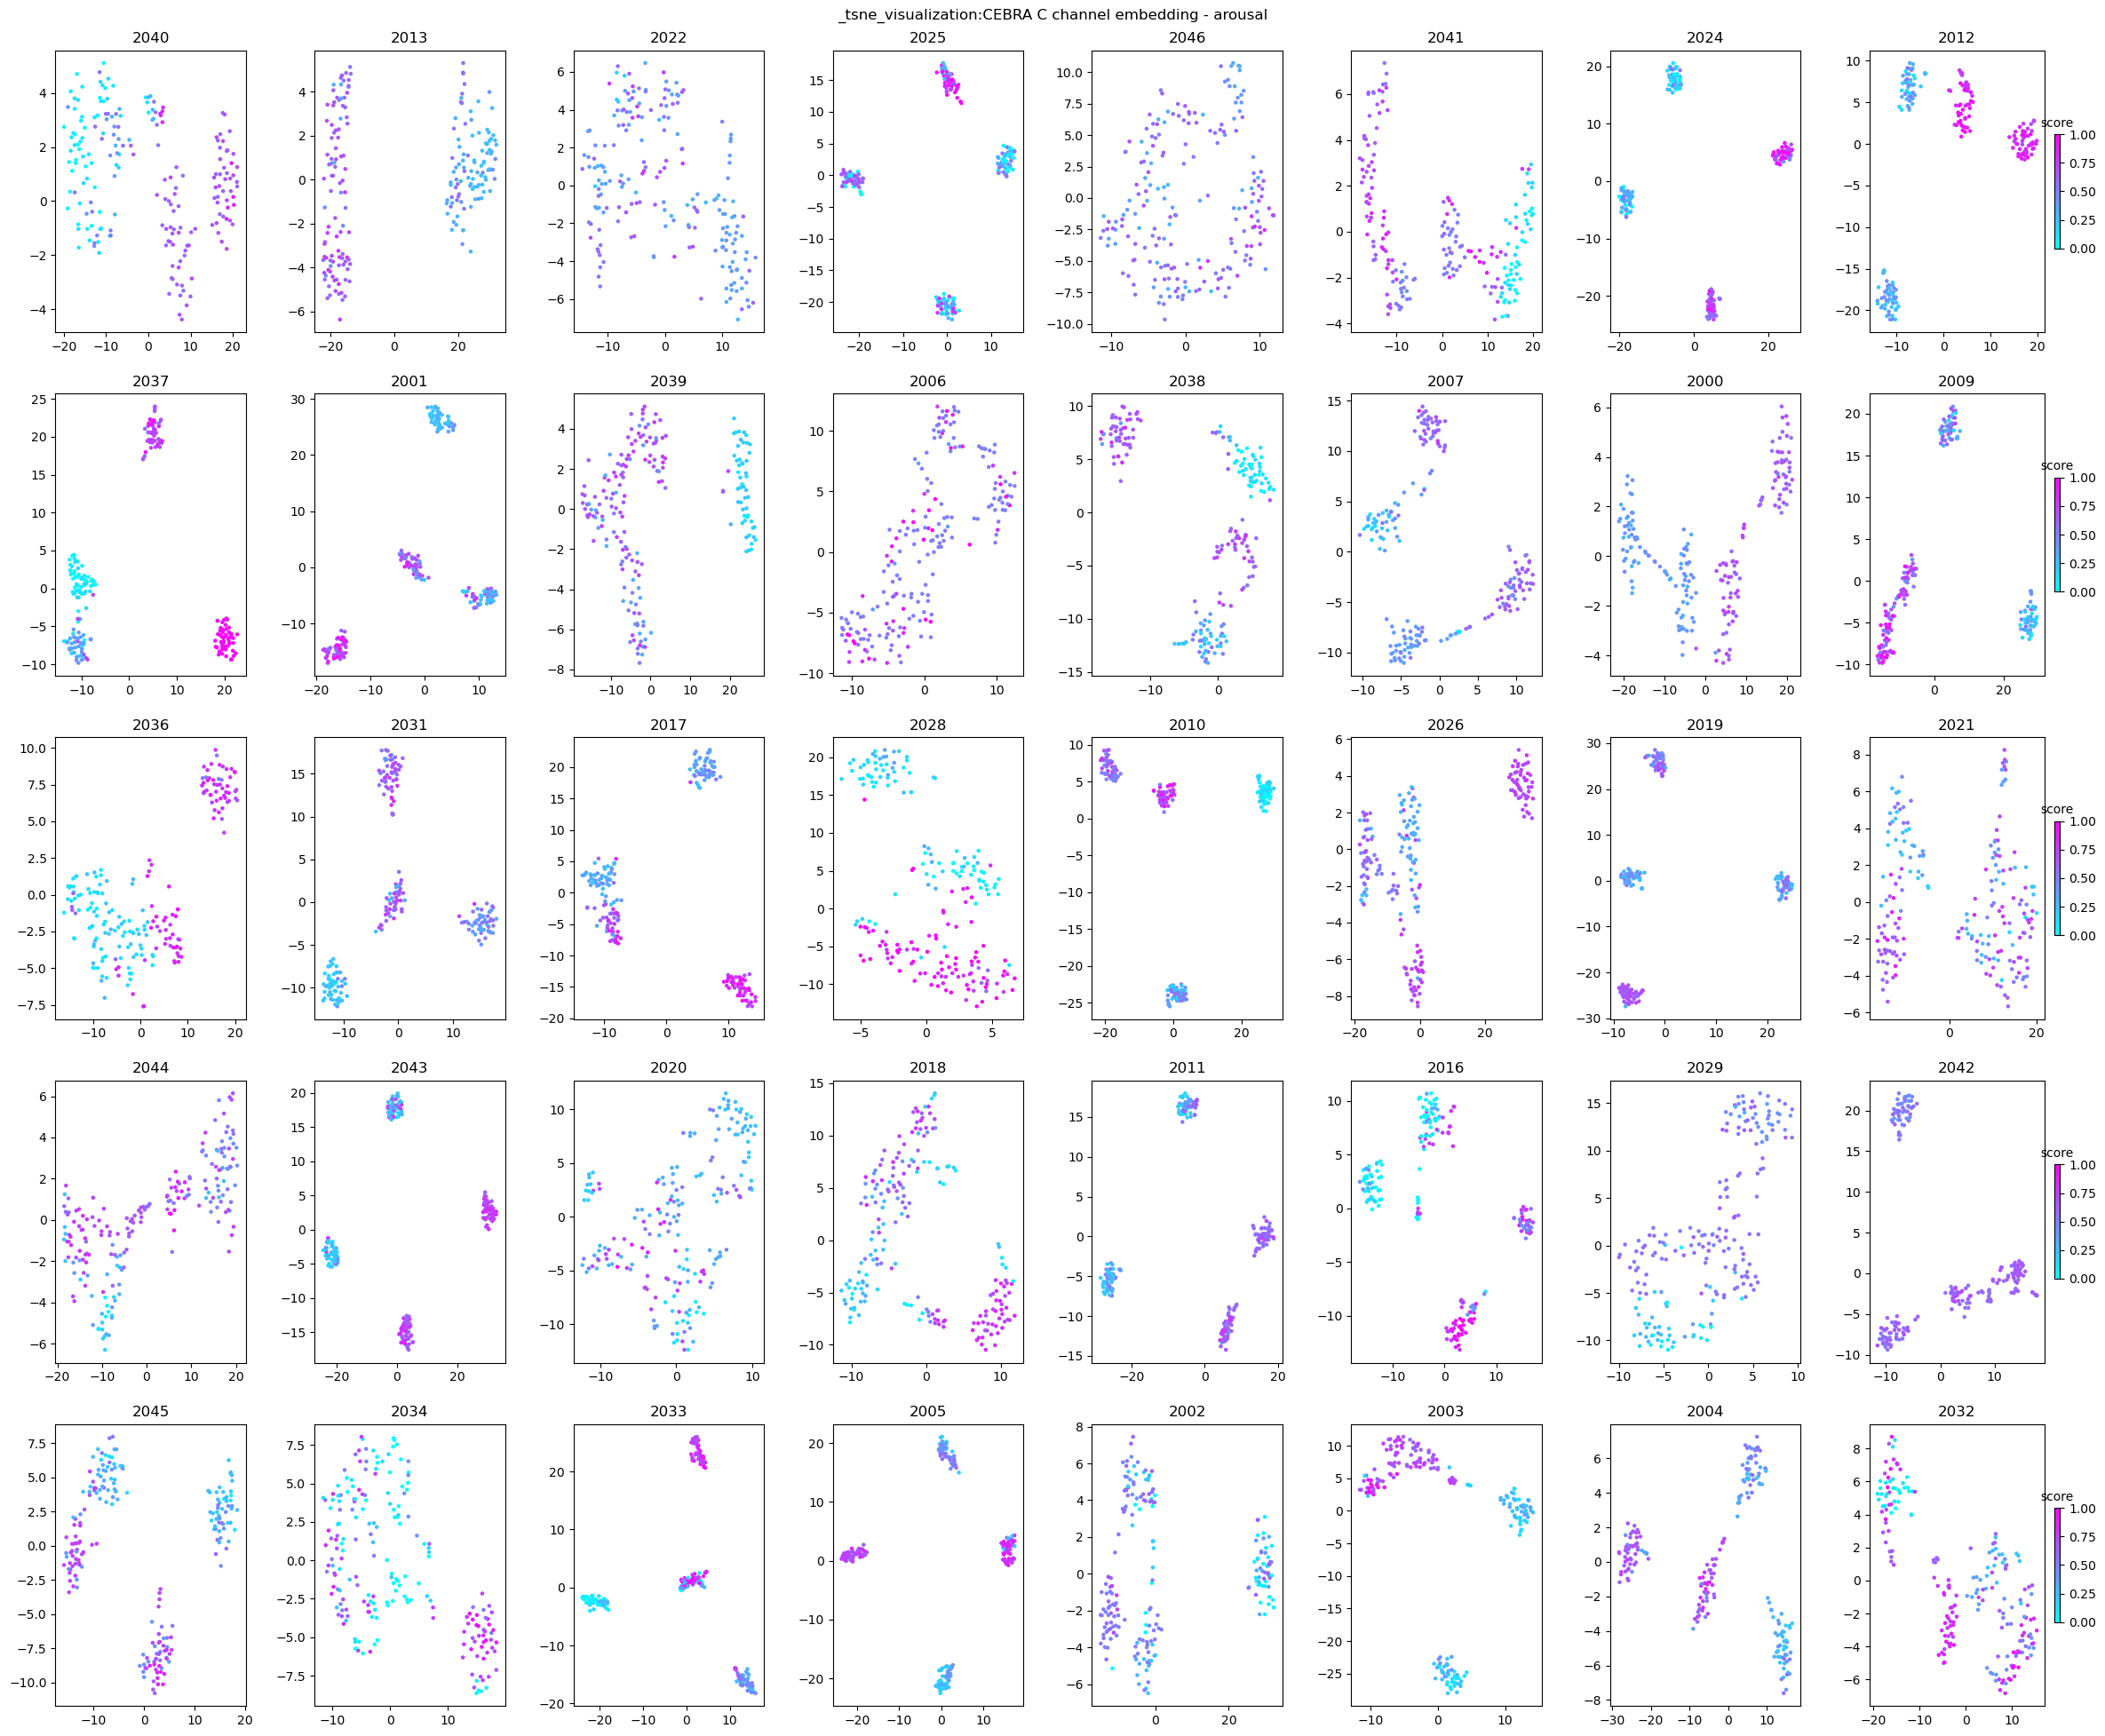

In [45]:
for label_type in ["valence", "arousal"]:
    n_row, n_col = (5, 8)
    fig, axes = plt.subplots(
        nrows=n_row,
        sharey=False,
        ncols=n_col,
        figsize=(n_col * 3, n_row * 4),
    )

    for idx, ax in enumerate(axes.flat):
        s = subject_list[idx]
        _, embeddings, embedding_labels = subject_to_embedding[s][label_type][0]

        proj_2d = _tsne_visualization(embeddings)
        y = ax.scatter(
            proj_2d[:, 0],
            proj_2d[:, 1],
            cmap="cool",
            c=embedding_labels,
            s=5,
            vmin=0,
            vmax=1,
        )
        ax.set_title(s)

        if idx % n_col == 7:
            yc = plt.colorbar(y, fraction=0.03, pad=0.05, ticks=np.linspace(0, 1, 5))
            yc.ax.tick_params(labelsize=10)
            yc.ax.set_title("score", fontsize=10)

    fig.suptitle(
        f"{_tsne_visualization.__name__}:{method} C channel embedding - {label_type}"
    )
    fig.tight_layout(pad=1.8)

## Attention investigation

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import math

test = np.array(attention_labels).ravel()
test = np.power(test, 1)
test = np.array(list(map(cutoff, test)))
scaler = MinMaxScaler(feature_range=(0, 1))
weights = scaler.fit_transform(test.reshape(-1, 1))

# Pass the NumPy array into the function


g = sns.histplot(
    data=mean_validation_score, stat="probability", cumulative=True
)
g.set_title("41 subjects attention rating in test")
g.axvline(np.mean(mean_validation_score), c="k", ls="-", lw=2.5)
g.axvline(np.median(mean_validation_score), c="orange", ls="--", lw=2.5)
g.set_ylim((0, 1))
g.set_xlim((0, 1))
#sns.displot(penguins, x="flipper_length_mm", kind="ecdf")

In [ ]:
# Define a  function to square elements
def cutoff(x):
    return math.pow(x, -2) if x > 50 else x

def nupsample_by_attention(attention, num_output):
    from sklearn.preprocessing import MinMaxScaler

    scaler = MinMaxScaler(feature_range=(0, 100))
    rating = np.array(attention).ravel()
    
    weights = scaler.fit_transform(np.power(rating, 1).reshape(-1, 1))
    weights = np.array(list(map(cutoff, weights.ravel())))

    resampled_features = random.choices(
        np.arange(0, len(attention), 1), weights=weights, k=num_output
    )

    return np.array(resampled_features)

def nget_resampled_list_index(train_indexes, attention_labels):
    # exclude validation
    train_attention_labels = np.array(attention_labels)[train_indexes]
    # up sample 4 times by attention labels
    resampled_list = nupsample_by_attention(
        train_attention_labels, len(train_attention_labels) * 4
    )
    return resampled_list

resampled_attention_list = []
for a in range(len(attention_labels)):
    for i in range(len(val_indexes)):
        train_indexes = list(set(range(len(attention_labels[a]))) - set(val_indexes[i]))
        resampled_list = nget_resampled_list_index(train_indexes, attention_labels[a])
        attention_list = np.array(attention_labels[a])[train_indexes][resampled_list]
        resampled_attention_list.append(attention_list.tolist())

In [ ]:
g = sns.histplot(
    data=np.array(resampled_attention_list).ravel(), stat="probability", cumulative=False
)
g.set_title("41 subjects w weighted attention distribution")
g.axvline(np.mean(np.array(resampled_attention_list)), c="k", ls="-", lw=2.5)
g.axvline(np.median(np.array(resampled_attention_list)), c="orange", ls="--", lw=2.5)
g.set_ylim((0, 0.2))
g.set_xlim((0, 1))

## MiSC: Loss/Grid search

In [ ]:
nrows = 1
ncols = len(loss_data)
fig, axes = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    sharey=True,
    figsize=(ncols * 5, nrows * 5),
)

fig.suptitle(
    f"Subject {subj}: {marker} {label_type} InfoNCE loss in audio condition",
    fontsize=15,
)

for c, ax in zip(loss_data.keys(), axes.flatten()):
    df = pd.DataFrame(loss_data[c])
    sns.lineplot(data=df, ax=ax)
    ax.set_title("channel:" + c)
    ax.set_ylabel("InfoNCE Loss")
    ax.set_xlabel("Steps")
# plt.savefig(f"results/cebra/{label_type}_{subj}_eeg_bands_channel_loss_{channel}_O{output_dim}H{max_hidden_units}.png")

In [ ]:
loss_dict = {"InfoNCE Loss": [], "band": [], "channel": [], "Steps": []}
for c, f_to_data in loss_data.items():
    for f, data in f_to_data.items():
        loss_dict["InfoNCE Loss"].extend(np.array(data))
        loss_dict["Steps"].extend(np.arange(0, len(data), dtype=int))
        loss_dict["band"].extend([f] * len(data))
        loss_dict["channel"].extend([c] * len(data))

loss_dict = pd.DataFrame(loss_dict)
loss_dict

In [ ]:
sns.lineplot(data=loss_dict, y="InfoNCE Loss", x="Steps", hue="band", style="channel")

In [ ]:
# 1. Define the parameters, either variable or fixed
params_grid = dict(
    output_dimension=[6, 8],
    learning_rate=[3e-4],
    max_iterations=10,
    num_hidden_units=[32, 64, 128, 256],
    max_adapt_iterations=10,
    temperature_mode="auto",
    verbose=False,
)

# 2. Define the datasets to iterate over
datasets = {
    "neural_data": channel_feature_to_data["C"][Feature.THETA],
}

# 3. Create and fit the grid search to your data
grid_search = cebra.grid_search.GridSearch()
grid_search = grid_search.fit_models(
    datasets=datasets, params=params_grid, models_dir="saved_models"
)

# 4. Get the results
df_results = grid_search.get_df_results(models_dir="saved_models")
# 5. Get the best model for a given dataset
best_model, best_model_name = grid_search.get_best_model(
    dataset_name="neural_data", models_dir="saved_models"
)